In [12]:
%matplotlib inline
import numpy as np
# import _pickle as cPickle
# import os
# import gzip
# from IPython.core.debugger import set_trace
# import scipy.optimize
import matplotlib.pyplot as plt
import tensorflow as tf

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys

# Second exercise: CNN
In this exercise you will implement a CNN

In [13]:
# load data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
print("mnist {}".format(mnist))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
mnist Datasets(train=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f669bdb6e80>, validation=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f669bdb6d30>, test=<tensorflow.contrib.learn.python.learn.datasets.mnist.DataSet object at 0x7f669bd02dd8>)


In [16]:
# define input variable
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])

# initialize weights with a small amount of noise for symmetry breaking, and to prevent 0 gradients
# The generated values follow a normal distribution with specified mean and standard deviation, 
# except that values whose magnitude is more than 2 standard deviations from the mean are dropped and re-picked.
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

# define constant bias
def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

# Computes a 2-D convolution given 4-D input and filter tensors. returning 4D tensor of same type as x
# ? means zero padding überall 2, oder ?
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

# first convolutional layer with 32 nodes --> woher die 32?? 
# initialise weights and bias (slightly randomized)
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

# define tensor representing input layer: reshape flattened 748 Vector to 4d tensor 28 x 28 image matrixes
# and the final dimension corresponding to the number of color channels.
x_image = tf.reshape(x, [-1, 28, 28, 1])

# convolve, same size (padding, stride...), reduce size to 14x14 by maxpooling
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

# define second layer concolving same size, max-pooling --> 7x7   64 features ??
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

# convolve, same size (padding, stride...), reduce size to 14x14 by maxpooling
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

# we add a fully-connected layer with 1024 neurons to allow processing on the entire image.
# We reshape the tensor from the pooling layer into a batch of vectors, multiply by a weight matrix, add a bias, 
# and apply a ReLU.
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

# implement dropout
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

# final fully connected layer
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [17]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  for i in range(100):
    batch = mnist.train.next_batch(50)
    if i % 50 == 0:
      train_accuracy = accuracy.eval(feed_dict={
          x: batch[0], y_: batch[1], keep_prob: 1.0})
      print('step %d, training accuracy %g' % (i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

  print("test")
  print('test accuracy %g' % accuracy.eval(feed_dict={
      x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

step 0, training accuracy 0.06
step 50, training accuracy 0.68
test
test accuracy 0.8562


# Neural Network class
With all layers in place (and properly implemented by you) we can finally define a neural network.
For our purposes a neural network is simply a collection of layers which we will cycle through and on which we will call fprop and bprop to compute partial derivatives with respect to the input and the parameters.

Pay special attention to the *check_gradients()* function in which you should implement automatic differentiation. This function will become your best friend when checking the correctness of your implementation.

In [5]:
class NeuralNetwork:
    """ Our Neural Network container class. # 
    """
    def __init__(self, layers):    # https://www.python-course.eu/python3_magic_methods.php __init is called automatically, here the method is overloaded
        self.layers = layers
        
    def _loss(self, X, Y):    # single underscore used by convention to avoid conflicts with python keywords
        Y_pred = self.predict(X)    # yields output of softmax
        return self.layers[-1].loss(Y, Y_pred)    # loss function of last layer

    def predict(self, X):    # forward pass through all layers, return Y_pred (Ŷ)   
        """ Calculate an output Y for the given input X. """
        # print("predict\n")
        next_output = X
        # set_trace()
        for l, layer in enumerate(self.layers):
            next_output = layer.fprop(next_output)    # z1 = layer.fprop(z0)
            # print("predict layer {} next_output \n{} \n".format(l,next_output))
        Y_pred = next_output
        return Y_pred         # (n,10), as returned by softmax --> to be interpreted as one hot encoded

    def backpropagate(self, Y, Y_pred, upto=0):    # updating all W,b params 
        """ Backpropagation of partial derivatives through 
            the complete network up to layer 'upto'
        """
        # backpropagate through all layers, start with last layer, there call input_grad() instead of bprop
        next_grad = self.layers[-1].input_grad(Y, Y_pred)   # returns "input_grad" dL/da3 of upper fully connected layer
        for layer in reversed(self.layers[upto:-1]):    # run backwards, from the second last down to "upto"
            next_grad = layer.bprop(next_grad) 

        return next_grad       # return gradient of last layer, dL/dX (n,D)
    
    def classification_error(self, X, Y):
        """ Calculate error on the given data 
            assuming they are classes that should be predicted. 
        """
        Y_pred = unhot(self.predict(X))     # convert softmax output vector --> digit 
        error = Y_pred != Y
        return np.mean(error)   # error rate

     
    def update_network(self, learning_rate):        # update all parameters given current gradients
        for lc, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):     # only parameterized layers, not input and output_layer
                layer.W = layer.W - layer.dW * learning_rate
                layer.b = layer.b - layer.db * learning_rate

                
    def sgd_epoch(self, X, Y, learning_rate, batch_size):
        n_samples = X.shape[0]
        n_batches = n_samples // batch_size      # define the number of mini batches
        for b in range(n_batches):
            batch_start = b * batch_size
            batch_end = (b + 1) * batch_size
            
            X_batch = X[batch_start:batch_end]
            Y_batch = Y[batch_start:batch_end]   # if batch_end too large --> gets ignored by numpy  
            
            Y_batch_pred = self.predict(X_batch)
            
            self.backpropagate(Y_batch, Y_batch_pred)
            
            self.update_network(learning_rate)
            
    def gd_epoch(self, X, Y, learning_rate):       # ? why no learning rate here ?
        # first attempt: whole dataset
        Y_pred = self.predict(X)         # predict Y based on given data and presend parameter settings
        # print("predict {}\n".format(Y_pred))
        self.backpropagate(Y, Y_pred)    # comparing Y and Y_pred calculate gradients of all parameters (stored in layers)

        # update all parameters of all layers
        self.update_network(learning_rate)

        
    def train(self, X, Y, X_val=[], Y_val=[], learning_rate=0.1, max_epochs=100, 
              batch_size=64, descent_type="sgd", y_one_hot=True):
        """ Train network on the given data. """

        train_errors = list()
        valid_errors = list()
        
        n_samples = X.shape[0]              
        n_batches = n_samples // batch_size
        if y_one_hot:           # !! y_one_hot = False yields error, because self.predict always un_hots 
            Y_train = one_hot(Y)
        else:
            Y_train = Y
        print("... starting training")
        for e in range(max_epochs+1):
            if descent_type == "sgd":
                self.sgd_epoch(X, Y_train, learning_rate, batch_size)
            elif descent_type == "gd":
                self.gd_epoch(X, Y_train, learning_rate)
            else:
                raise NotImplementedError("Unknown gradient descent type {}".format(descent_type))

            # Output error on the training data
            train_loss = self._loss(X, Y_train)             # calls one forward pass given X and computes loss on result
            train_error = self.classification_error(X, Y) * 100  # calls one forward pass given X and counts error-rate (in % of all data)
            train_errors.append(train_error)

            if len(X_val) > 0:
                valid_error = self.classification_error(X_val, Y_val) * 100   # 
                valid_errors.append(valid_error)

                print('epoch {} loss {:.4f}, train error {:.3f}%, valid error {:.3f}%'.\
                      format(e, train_loss, train_error, valid_error))            
            else:
                print('epoch {} loss {:.4f}, train error {:.3f}%'.\
                      format(e, train_loss, train_error))            

        return(train_errors, valid_errors)

    
    def check_gradients(self, X, Y):
        """ Helper function to test the parameter gradients for
        correctness. """
        for l, layer in enumerate(self.layers):
            if isinstance(layer, Parameterized):      # not for layers without parameters (input / output)
                print('checking gradient for layer {}'.format(l))
                for p, param in enumerate(layer.params()):    # layer.params() returns layer.W and layer.b (p=tuple(2,))
                    # we iterate through all parameters, first W then b
                    param_shape = param.shape

                    def output_given_params(param_new):  # return output / loss of total network given new params
                        """ A function that will compute the output 
                            of the network given a set of parameters
                        """
                        # assign new params to param of this layer, referenced by param[:]
                        param[:] = np.reshape(param_new, param_shape)    # 
                        # return loss, computed with these new params
                        return self._loss(X, Y)

                    def grad_given_params(param_new):     # return grad of this param (W or b) given the param
                        """A function that will compute the gradient 
                           of the network given a set of parameters
                        """
                        # assign new param W or b to this layer, referenced by param[:]
                        param[:] = np.reshape(param_new, param_shape)
                        
                        Y_pred = self.predict(X)               # prediction based on new params, softmax output vector (n,10)
                        # backpropagate given new Y_pred, update all gradients dW, db up to this layer 
                        self.backpropagate(Y, Y_pred, upto=l)  # Backpropagation of partial derivatives 
                        return np.ravel(self.layers[l].grad_params()[p])

                    # let the initial parameters be the ones that
                    # are currently placed in the network and flatten them
                    # to a vector for convenient comparisons, printing etc.
                    param_init = np.ravel(np.copy(param))

                    epsilon = 1e-4
                    # sci_err = scipy.optimize.check_grad(output_given_params, grad_given_params, param_init, epsilon=epsilon)
                    # print('scipy_grad_error {:.2e} \n'.format(sci_err))                    
                    
                    loss_base = output_given_params(param_init)    # scalar loss at current params

                    # for each single element of W,b make eps step and calculate finite difference
                    gparam_fd = np.zeros_like(param_init)    # gradient calculated through finited differences
                    new_param = np.zeros_like(param_init)    # new, eps-deviated param for testing
                    for i in range(param_init.shape[0]):     # go through all rows and colums of this W or b 
                        new_param[:] = param_init            # set back to orignial value

                        new_param[i] = param_init[i] + epsilon    # vary only for this element
                        loss_plus = output_given_params(new_param)           

                        gparam_fd[i] = (loss_plus - loss_base) / (epsilon)   # dfferential --> approximated gradient                            
                    
                    gparam_bprop = grad_given_params(param_init)  # gradient als calculated by bprop

                    err = np.sqrt(np.sum((gparam_bprop - gparam_fd)**2))  # same as in SciPi 
                    print('grad_error {:.2e}'.format(err))
                    
                    # reset the parameters to their initial values
                    param[:] = np.reshape(param_init, param_shape)

In [7]:
# first micro toy network for preliminary tests
X = np.array([[1.,2.,3.],[2.,5.,3.],[2.,4.,6.],[1.,2.,3.]])   
y = np.array([1,2,0,1])

mini_layers = [InputLayer(X.shape)]
mini_layers.append(FullyConnectedLayer(
                mini_layers[-1],      
                num_units=5,    
                init_stddev=0.1,
                activation_fun=Activation('relu')
                # activation_fun = None    
))
mini_layers.append(FullyConnectedLayer(
                mini_layers[-1],      
                num_units=2,    
                init_stddev=0.1,
                activation_fun=Activation('sigmoid')
                # activation_fun = None    
))
mini_layers.append(FullyConnectedLayer(
                mini_layers[-1],      
                num_units=3,    # number of classes = number of different digits in y
                init_stddev=0.1,
                # activation_fun=Activation('relu')
                activation_fun = None    
))
mini_layers.append(SoftmaxOutput(mini_layers[-1]))

nn_mini = NeuralNetwork(mini_layers)
y_one_hot = one_hot(y)
nn_mini.train(X, y, learning_rate=0.1, 
              max_epochs=5, batch_size=2, descent_type="sgd", y_one_hot=True)

... starting training
epoch 0 loss 1.0900, train error 50.000%
epoch 1 loss 1.0801, train error 50.000%
epoch 2 loss 1.0720, train error 50.000%
epoch 3 loss 1.0654, train error 50.000%
epoch 4 loss 1.0601, train error 50.000%
epoch 5 loss 1.0558, train error 50.000%


([50.0, 50.0, 50.0, 50.0, 50.0, 50.0], [])

# Gradient Checking
After implementing everything it is always a good idea to setup some layers and perform gradient
checking on random data. **Note** that this is only an example! It is not a useful network architecture ;). We also expect you to play around with this to test all your implemented components.

In [8]:
input_shape = (5, 10)
n_labels = 6
layers = [InputLayer(input_shape)]

layers.append(FullyConnectedLayer(
                layers[-1],      
                num_units=15,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=6,
                init_stddev=0.1,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=n_labels,
                init_stddev=0.1,
                activation_fun=Activation('relu')
))
layers.append(SoftmaxOutput(layers[-1]))
nn = NeuralNetwork(layers)

In [9]:
# create random data
X = np.random.normal(size=input_shape)
# and random labels
Y = np.zeros((input_shape[0], n_labels))
for i in range(Y.shape[0]):
    idx = np.random.randint(n_labels)
    Y[i, idx] = 1.

In [10]:
nn.check_gradients(X, Y)

checking gradient for layer 1
grad_error 1.24e-07
grad_error 1.92e-08
checking gradient for layer 2
grad_error 2.53e-07
grad_error 4.29e-07
checking gradient for layer 3
grad_error 1.24e-07
grad_error 1.03e-05


# Training on MNIST
Finally we can let our network run on the MNIST dataset!

In [11]:
Dtrain, Dval, Dtest = mnist()
X_train, y_train = Dtrain
X_valid, y_valid = Dval
X_test,  y_test  = Dtest
# Downsample training data to make it a bit faster for testing this code
n_train_samples = 100000   # larger than actual number of samples --> take all data
n_valid_samples = 100000
n_test_samples = 100000

train_idxs = np.random.permutation(X_train.shape[0])[:n_train_samples]
X_train = X_train[train_idxs]
y_train = y_train[train_idxs]

valid_idxs = np.random.permutation(X_valid.shape[0])[:n_valid_samples]
X_valid = X_valid[valid_idxs]
y_valid = y_valid[valid_idxs]

test_idxs = np.random.permutation(X_test.shape[0])[:n_test_samples]
X_test = X_test[test_idxs]
y_test = y_test[test_idxs]

... loading data
... done loading data


*Dtrain* contains 50k images which are of size 28 x 28 pixels. Hence:

In [12]:
print("X_train shape: {}".format(np.shape(X_train)))
print("y_train shape: {}".format(np.shape(y_train)))

print("y_valid shape: {}".format(np.shape(y_valid)))
print("y_test shape: {}".format(np.shape(y_test)))

X_train shape: (50000, 1, 28, 28)
y_train shape: (50000,)
y_valid shape: (10000,)
y_test shape: (10000,)


y_train will automatically be converted in the *train()* function to one_hot encoding.


But we need to reshape X_train, as our Network expects flat vectors of size 28*28 as input!

In [13]:
X_train = X_train.reshape(X_train.shape[0], -1)
print("Reshaped X_train size: {}".format(X_train.shape))
X_valid = X_valid.reshape(X_valid.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

Reshaped X_train size: (50000, 784)


Ah, much better ;-)! 

Now we can finally really start training a Network!


I pre-defined a small Network for you below. Again This is not really a good default and will not produce state of the art results. Please play around with this a bit. See how different activation functions and training procedures (gd / sgd) affect the result.

In [15]:
import time

# Setup a small MLP / Neural Network
# we can set the first shape to None here to indicate that
# we will input a variable number inputs to the network
input_shape = (None, 28*28)
layers = [InputLayer(input_shape)]
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('relu')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=100,
                init_stddev=0.01,
                activation_fun=Activation('tanh')
))
layers.append(FullyConnectedLayer(
                layers[-1],
                num_units=10,        # last layer has 10 units, one for each figure --> one hot encoding
                init_stddev=0.01,
                # last layer has no nonlinearity 
                # (softmax will be applied in the output layer)
                activation_fun=None 
))
layers.append(SoftmaxOutput(layers[-1]))

nn = NeuralNetwork(layers)
# Train neural network
t0 = time.time()
train_errors, valid_errors = nn.train(X_train, y_train, X_valid, y_valid, learning_rate=0.3, 
         max_epochs=10, batch_size=60, descent_type="sgd", y_one_hot=True)
t1 = time.time()
print('Duration: {:.1f}s'.format(t1-t0))

test_err = nn.classification_error(X_test,y_test)
print("\nTest Error: {}".format(test_err))

... starting training
epoch 0 loss 0.1576, train error 5.012%, valid error 4.940%
epoch 1 loss 0.0879, train error 2.764%, valid error 3.380%
epoch 2 loss 0.0635, train error 1.992%, valid error 2.910%
epoch 3 loss 0.0497, train error 1.606%, valid error 2.790%
epoch 4 loss 0.0464, train error 1.538%, valid error 3.010%
epoch 5 loss 0.0269, train error 0.848%, valid error 2.740%
epoch 6 loss 0.0461, train error 1.524%, valid error 3.240%
epoch 7 loss 0.0202, train error 0.678%, valid error 2.630%
epoch 8 loss 0.0127, train error 0.430%, valid error 2.470%
epoch 9 loss 0.0257, train error 0.856%, valid error 2.630%
epoch 10 loss 0.0097, train error 0.292%, valid error 2.390%
Duration: 65.7s

Test Error: 0.0256


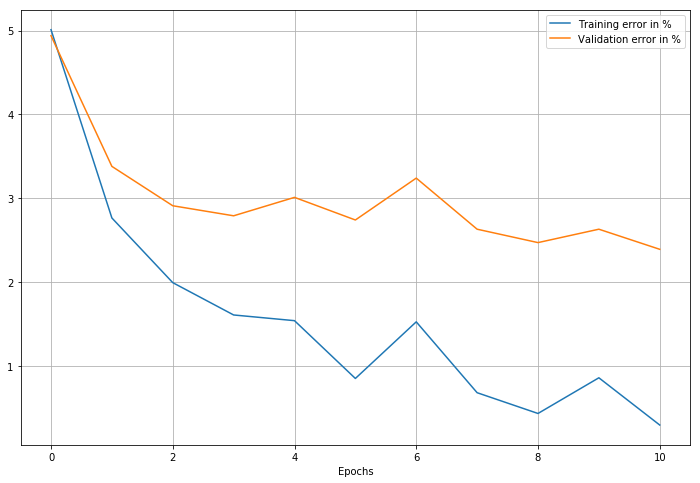

In [17]:
plt.figure(figsize=(12, 8))
plt.plot(train_errors, label='Training error in %')
plt.plot(valid_errors, label='Validation error in %')
plt.grid(True)
plt.xlabel("Epochs")
plt.legend(loc='best')

Correctly / incorrectly classified images (first / second row)


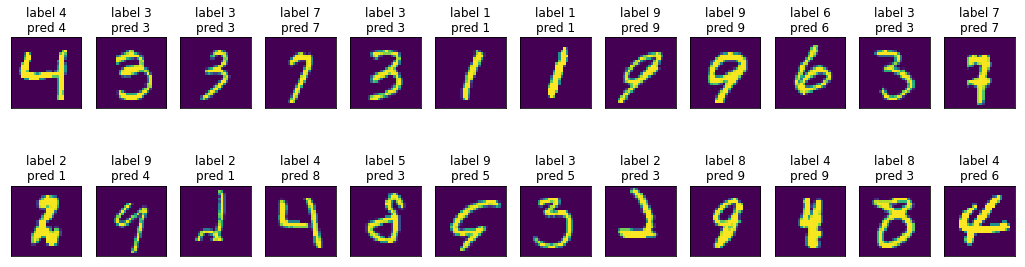

In [18]:
start = 30        # starting point in Lists of Images to be displayed
                  # select arbitrarily to view different images
n_images = 12     # number of images in display

y_valid_pred = unhot(nn.predict(X_valid))

# print("y_valid_pred \n{}".format(y_valid_pred[:20]))
# print("y_valid \n{}".format(y_valid[:20]))

X_True =  X_valid[y_valid == y_valid_pred]
L_True =  y_valid[y_valid == y_valid_pred]
L_True_pred = y_valid_pred[y_valid == y_valid_pred]

X_False = X_valid[y_valid != y_valid_pred]
L_False = y_valid[y_valid != y_valid_pred]
L_False_pred = y_valid_pred[y_valid != y_valid_pred]

True_images = X_True[start:n_images+start][:].reshape(n_images,28,28)
True_Labels = L_True[start:n_images+start]
True_Labels_pred = L_True_pred[start:n_images+start]
False_images = X_False[start:n_images+start][:].reshape(n_images,28,28)
False_Labels = L_False[start:n_images+start]
False_Labels_pred = L_False_pred[start:n_images+start]

print("Correctly / incorrectly classified images (first / second row)")

fig, axes = plt.subplots(2, n_images, squeeze=False, figsize=(18,5))

for i in range(n_images):
        axes[0][i].imshow(True_images[i], interpolation='nearest')
        axes[0][i].set_title('label ' + str(True_Labels[i])+ '\n' + 'pred ' + str(True_Labels_pred[i]))
        axes[0][i].grid(False)
        axes[0][i].set_xticks([])
        axes[0][i].set_yticks([])   
        
for i in range(n_images):
        axes[1][i].imshow(False_images[i], interpolation='nearest')
        axes[1][i].set_title('label ' + str(False_Labels[i])+ '\n' + 'pred ' + str(False_Labels_pred[i]))        
        axes[1][i].grid(False)
        axes[1][i].set_xticks([])
        axes[1][i].set_yticks([]) 